# Exploring the Quantum Nature of Light with Compton Scattering

Sam Greydanus. 11 May 2017. Experimental Methods in Physics.

In [1]:
import read_chn
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
data_dir = './data'

elements = ['cs', 'na', 'co']
angles = [str(i).zfill(2) for i in range(0,70,10)]
calib_files = {e : '/calib-f/{}.Chn'.format(e) for e in elements}
scatter_files = {a : '/data-f/cs_{}_scatter.Chn'.format(a) for a in angles}
control_files = {a : '/data-f/cs_{}_control.Chn'.format(a) for a in angles}

In [3]:
def load_chn(fname):    
    spec_obj    = read_chn.gamma_data(fname)
    spec_array  = spec_obj.hist_array
    spec_time   = spec_obj.real_time   
    return spec_array, spec_time

calib = {k : load_chn(data_dir + v)[0] for (k, v) in calib_files.items()}
scatter = {k : load_chn(data_dir + v)[0] for (k, v) in scatter_files.items()}
control = {k : load_chn(data_dir + v)[0] for (k, v) in control_files.items()}

In [4]:
# normalize
for e in elements:
    calib[e] = calib[e] / np.sum(calib[e])
    
for a in angles:
    scatter[a] = scatter[a] / np.sum(scatter[a])
    control[a] = control[a] / np.sum(control[a])

## Inspect calibration data

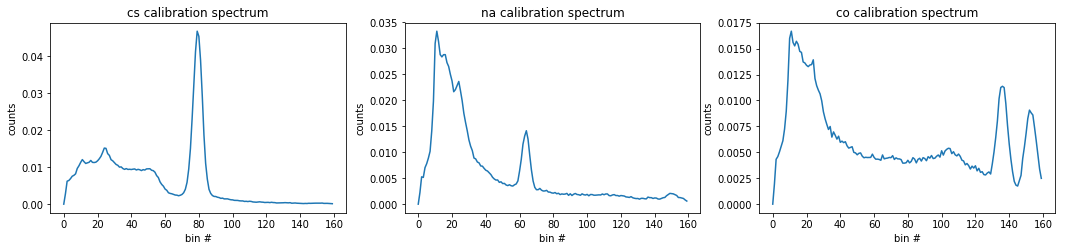

In [5]:
vplots = 1
hplots = 3
plot_i = 0
clip = 160
fs = [hplots*6, 3.5*vplots]
f1 = plt.figure(figsize=fs)
for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title(elements[plot_i] + ' calibration spectrum')
        plt.xlabel("bin #") ; plt.ylabel("counts")
        plt.plot(calib[elements[plot_i]][:clip])
        plot_i += 1
        
plt.show() ; f1.savefig("./figures/calib.pdf", bbox_inches='tight')

## Estimate bin-to-energy mapping
Simple peak-finding algorithm:
1. Given a threshold, it finds all the bins with values greater than that threshold
2. Next, it uses that information to find all the bins where the inflection from to 
    below-threshold to above-threshold happens
3. It averages the indices of these "inflection" bins in pairs of twos to estimate
    the center of the peak. This works, as long as the shape of the peak is roughly symmetric

In [6]:
def simple_find_peak(raw_dat, thresh):
    dat = raw_dat > thresh
    dat = np.stack([dat[i] is not dat[i+1]  for i in range(len(dat)-1)])
    inflections = np.where(dat > 0.5)[0]
    inflections = inflections.reshape(-1,2)
    peaks = np.mean(inflections,axis=1).ravel()
    return peaks

thresh = {'na': 0.01, 'co': 0.0075, 'cs':0.04}
peaks = {}
for e in elements:
    p = simple_find_peak(calib[e], thresh[e])
    peaks[e] = p

Throw away some peaks:
Cs: throw away no peaks; for the theshold we chose, there is only one peak
Na: throw away the first peak - it's backgroud. We also miss the second peak 
    of Na in this analysis, but it's no big deal as we already have enough 
    parameters to get a good fit
Co: Throw away the first peak - it's background

This "throwing away" business is a little handwavy. We do it because peak 
    finding is a difficult task and because we've already manually inspected
    the data, above

In [7]:
peaks['cs'] = (peaks['cs']).tolist()
peaks['na'] = (peaks['na'][1:]).tolist()
peaks['co'] = (peaks['co'][1:]).tolist()
peaks

{'co': [135.5, 152.0], 'cs': [78.5], 'na': [63.0]}

Found data for
1. Cs peak: lab report
2. Na peak: http://www.amptek.com/wp-content/uploads/2013/12/nai_a.gif
3. Co peak: https://www.andrews.edu/phys/wiki/PhysLab/lib/exe/fetch.php?media=lab14.fig.2.jpg

_Omitted the second peak from Na, because we didn't pick it up when peak finding (see above)_

In [8]:
peak_energies = {'co': [1170., 1330.], 'cs': [662.], 'na': [511.]}

### Plot peak energy vs. bin location
Also, fit a line to it!

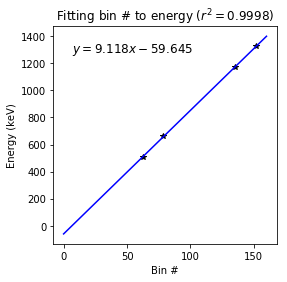

In [9]:
x = np.stack( peaks['cs'] + peaks['co'] + peaks['na'] )
y = np.stack( peak_energies['cs'] + peak_energies['co'] + peak_energies['na'] )
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

fit_x = np.linspace(0,clip, clip+1)
fit_y = slope*fit_x + intercept

f2 = plt.figure(figsize=[4,4])
sign = '-' if intercept < 0 else '+'
f2.text(0.4, .8, '$y={:.3f}x{}{:.3f}$'.format(slope, sign, np.abs(intercept)), ha='center', va='center', fontsize=12)

plt.title("Fitting bin # to energy ($r^2={:.4f}$)".format(r_value**2))
plt.xlabel("Bin #") ; plt.ylabel("Energy (keV)")
plt.plot(x, y, 'k*')
plt.plot(fit_x, fit_y, 'b-', label='best fit')
plt.show() ; f2.savefig("./figures/regress.pdf", bbox_inches='tight')

## Inspect scattering data

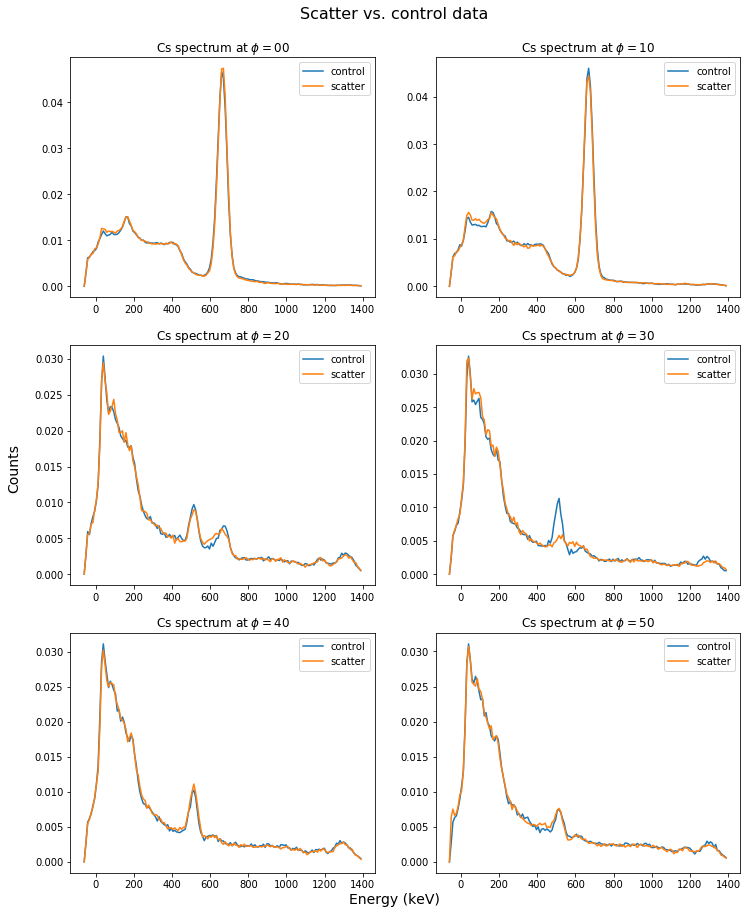

In [10]:
vplots = 3
hplots = 2
plot_i = 0
labels = []
fs = [hplots*6, 5*vplots]
f3 = plt.figure(figsize=fs)

f3.text(0.5, .92, 'Scatter vs. control data', ha='center', va='center', fontsize=16)
f3.text(0.5, 0.1, 'Energy (keV)', ha='center', va='center', fontsize=14)
f3.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical', fontsize=14)

for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title('Cs spectrum at $\phi={}$'.format(angles[plot_i]))
        plt.plot(fit_y[:clip], control[angles[plot_i]][:clip], label='control')
        plt.plot(fit_y[:clip], scatter[angles[plot_i]][:clip], label='scatter') ; plt.legend()
        plot_i += 1
        
plt.show() ; f3.savefig("./figures/compare.pdf", bbox_inches='tight')

## Difference between scattering and control data

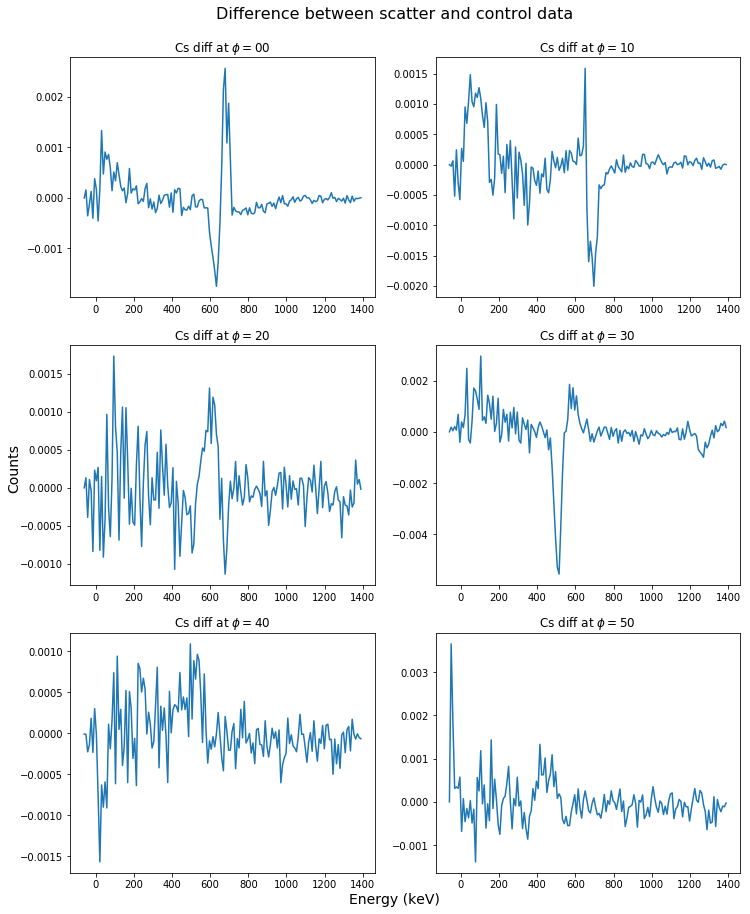

In [11]:
vplots = 3
hplots = 2
plot_i = 0
labels = []
fs = [hplots*6, 5*vplots]
f4 = plt.figure(figsize=fs)

f4.text(0.5, .92, 'Difference between scatter and control data', ha='center', va='center', fontsize=16)
f4.text(0.5, 0.1, 'Energy (keV)', ha='center', va='center', fontsize=14)
f4.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical', fontsize=14)

for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title('Cs diff at $\phi={}$'.format(angles[plot_i]))
        plt.plot(fit_y[:clip], (scatter[angles[plot_i]]-control[angles[plot_i]])[:clip])
        plot_i += 1
        
plt.show() ; f4.savefig("./figures/diffs.pdf", bbox_inches='tight')

In the figures above, the sharp transitions from positive to negative regions are signals that the scattering peak has shifted with respect to the control peak. Where are these transitions occuring? If our data was less messy, we could write another automated algorithm to detect these transitions. As things are, we'll have to eyeball these transitions.